In [1]:
from datetime import datetime
import glob
import matplotlib.dates as mdates
import matplotlib.pyplot as plt 
import os
import numpy as np 
import pandas as pd
import pytz
%matplotlib widget

# Formatting for plots
label_font = {'fontname':'sans-serif', 'size':'16', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} 
title_font = {'fontname':'sans-serif', 'size':'16', 'color':'black', 'weight':'bold'}
legend_font = {'family':'sans-serif', 'size':'12', 'style':'normal', 'weight':'bold'} 

# Get a list of files in a directory
def getFiles(dirName):
    os.chdir(dirName)
    allFiles = np.asarray(glob.glob("*.txt"))
    # Sort files - Note that this will not work if you have a different enumeration setup (e.g. you don't have an underscore)
    allFiles = sorted(allFiles, key = lambda x: float(x[x.rindex('_') + 1:x.index('.')]))
    #print(allFiles)
    return allFiles[:]

# Read data from data files
def getData(aFile):
    times = []
    deltas = []
    with open(aFile, 'r') as f:
        f.readline()
        for aLine in f:
            holder = aLine.split('\t')
            aDate = datetime.strptime(holder[0], '%m/%d/%Y %H:%M:%S.%f:')
            if float(holder[1].strip()) < 1e5:
                times.append(aDate)
                deltas.append(float(holder[1].strip()))
    return times, deltas



MAX: 154.224 ns
MIN: 0.0ps
μ: 4.157ns
σ: 19.619ns


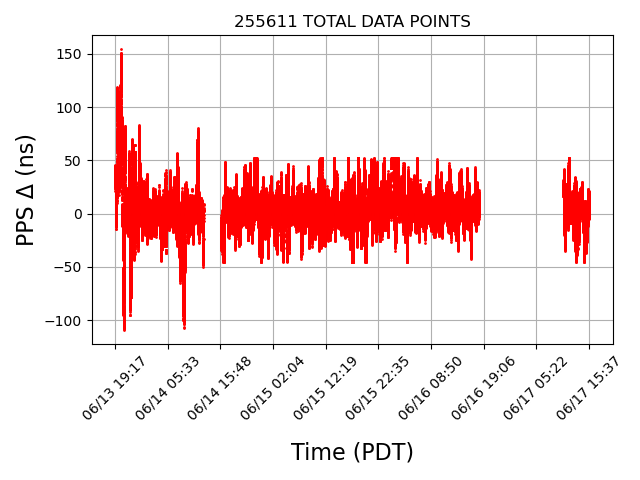

In [28]:
# Location of data directory
dataDir = '/home/bgodfrey/Berkeley/ScopeData/'
allFiles = getFiles(dataDir)

allTimes = []
allDeltas = []

# Get a list of files
for aFile in allFiles:
    holderTimes, holderDeltas = getData(aFile)
    allTimes = np.concatenate((allTimes, holderTimes))
    allDeltas = np.concatenate((allDeltas, holderDeltas))

#print(np.median(np.abs(allDeltas)))

plt.close('all')
plt.figure()

# Failed plotting formatting
# '%m/%d %H:00'
#locator = mdates.AutoDateLocator(minticks = 5, maxticks = 10, interval_multiples = True)
#plt.gca().xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))    
#for aLabel in plt.gca().get_xticklabels(which='major'):
#    aLabel.set(rotation=-30, horizontalalignment='right')


# Formatting the time axis by converting all the times to seconds since 1/1/1970 - needed to do this since Matplotlib doesn't
# respect your tics unless they are numbers 
totalTics = 10
minTic = allTimes[0].timestamp()
maxTic = allTimes[-1].timestamp()
#stepSize = (maxTic - minTic) / (totalTics - 1)

# Get locations of all the tics
allTics = np.arange(minTic, maxTic + 0.99 * stepSize, stepSize)
#print(allTics)

# Overwrit the labels with custom dates
labelTimes = [datetime.fromtimestamp(x).strftime("%m/%d %H:%M") for x in allTics]
labelSecs = [x.timestamp() for x in allTimes]
#print(labelTimes)

plt.plot(np.asarray(labelSecs), allDeltas, 'r.', markersize = 2)
#plt.gca().locator_params(axis='x', tight = True, nbins=totalTics)
plt.gca().set_xticks(np.arange(labelSecs[0],labelSecs[-1] + 0.99*(labelSecs[1] - labelSecs[0]), (labelSecs[-1] - labelSecs[0])/(totalTics-1)))

#xticks = plt.gca().get_xticks()

# Plotting and formatting
plt.gca().set_xticklabels(labelTimes, rotation = 45)
plt.xlabel('Time (PDT)', labelpad = 30, **label_font)
plt.ylabel(u'PPS \u0394 (ns)', **label_font)
plt.grid()
plt.title(str(len(allDeltas)) + ' TOTAL DATA POINTS')
plt.tight_layout()

# Print some info about the plotted data
print('MAX: ' + str(max(np.abs(allDeltas))) + ' ns')
print('MIN: ' + str(min(np.abs(allDeltas)*1000)) + 'ps')

print(u'\u03BC: ' + str(round(np.mean(allDeltas[:]), 3)) + 'ns')
print(u'\u03C3: ' + str(round(np.std(allDeltas), 3)) + 'ns')

NUMBER OF BINS: 484


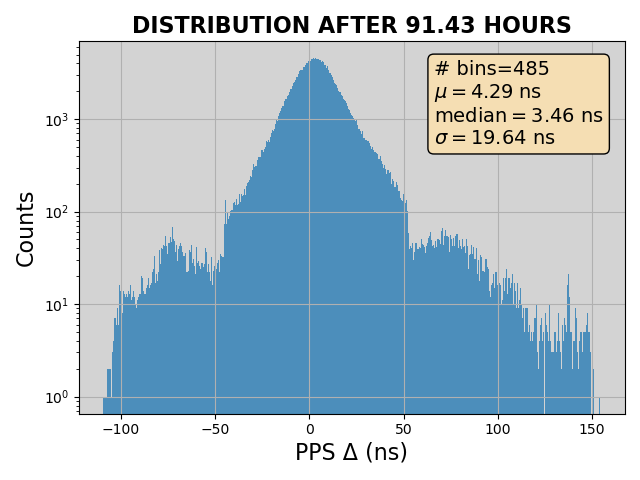

In [24]:
# Setting the number of bins using the Freedman–Diaconis rule
iqr = np.subtract(*np.percentile(allDeltas, [75, 25]))
binWidth = 2*iqr/(len(allDeltas)**(1/3.))
numBins = int((max(allDeltas) - min(allDeltas))/binWidth)
print('NUMBER OF BINS: ' + str(numBins))

plt.close('all')
plt.figure()
plt.grid()
# Histogram the data
n, bins, patches = plt.hist(allDeltas, bins = numBins, alpha = 0.75)

plt.xlabel(u'PPS \u0394 (ns)', labelpad = 20, **label_font)
plt.ylabel('Counts', **label_font)
plt.tight_layout()

# Print some info about the histogram and format it
allDeltas = np.asarray(allDeltas)
mu = allDeltas.mean()
median = np.median(allDeltas)
sigma = allDeltas.std()
textstr = '\n'.join((
    r'# bins=%.0f ' %(len(bins)),
    r'$\mu=%.2f$ ns' % (mu, ),
    r'$\mathrm{median}=%.2f$ ns' % (median, ),
    r'$\sigma=%.2f$ ns' % (sigma, )))

# matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

# place a text box in upper left in axes coords
plt.gca().text(0.65, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=props)

totalDataTime = (allTimes[-1].timestamp() - allTimes[0].timestamp())/3600
plt.title('DISTRIBUTION AFTER ' + str(round(totalDataTime,2)) + ' HOURS', **title_font)
plt.gca().set_yscale('log')
plt.gca().set_facecolor('lightgrey')
plt.tight_layout()


NUMBER OF BINS: 190


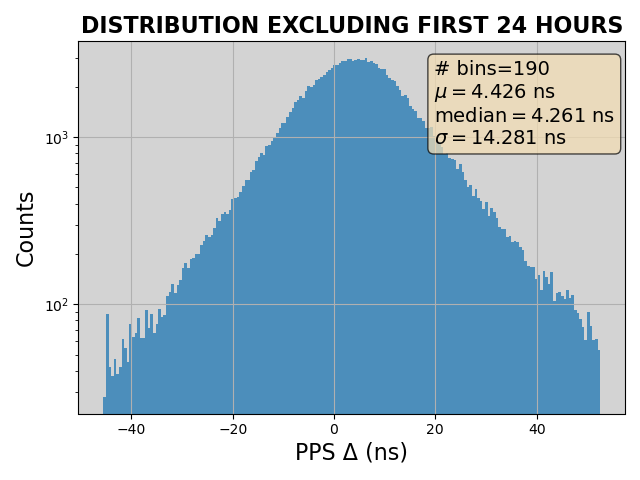

In [25]:
# This does the same thing as the previous code block it just removes the first part of the dataset
startTime = 24 # In hours
reducedDeltas = np.asarray(allDeltas[startTime*60*60:])
iqr = np.subtract(*np.percentile(reducedDeltas, [75, 25]))
binWidth = 2*iqr/(len(allDeltas)**(1/3.))
numBins = int((max(reducedDeltas) - min(reducedDeltas))/binWidth)
print('NUMBER OF BINS: ' + str(numBins))
plt.close('all')
plt.figure()
plt.grid()
n, bins, patches = plt.hist(reducedDeltas, bins = numBins, alpha = 0.75)


plt.xlabel(u'PPS \u0394 (ns)', labelpad = 20, **label_font)
plt.ylabel('Counts', **label_font)
plt.tight_layout()

mu = reducedDeltas.mean()
median = np.median(reducedDeltas)
sigma = reducedDeltas.std()
textstr = '\n'.join((
    r'# bins=%.0f ' %(len(n)),
    r'$\mu=%.3f$ ns' % (mu, ),
    r'$\mathrm{median}=%.3f$ ns' % (median, ),
    r'$\sigma=%.3f$ ns' % (sigma, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)

# place a text box in upper left in axes coords
plt.gca().text(0.65, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=props)
plt.title('DISTRIBUTION EXCLUDING FIRST ' + str(startTime) + ' HOURS', **title_font)
plt.gca().set_yscale('log')
plt.gca().set_facecolor('lightgrey')
plt.tight_layout()


In [2]:
# Get all files

dirName = '/home/bgodfrey/Berkeley/ScopeData/'
allFiles = getFiles(dirName)
allTimes = []
allDeltas = []

# Get a list of files
for aFile in allFiles:
    holderTimes, holderDeltas = getData(aFile)
    allTimes = np.concatenate((allTimes, holderTimes))
    allDeltas = np.concatenate((allDeltas, holderDeltas))

#print(allTimes[0])

# Defaults to PT convert to UTC
# Make times into a timezone-aware datetime object
localTime = pytz.timezone("America/Los_Angeles")
localDT = [localTime.localize(x, is_dst=None) for x in allTimes]
utcDT = [(x.astimezone(pytz.utc)).strftime("%m/%d/%Y %H:%M:%S.%f") for x in localDT]

writeDir = './'
writeName = 'allData.csv'
df = pd.DataFrame(data={"date (UTC)": utcDT[:], "deltas (ns)": allDeltas[:]})
df.to_csv(writeDir + writeName, sep=',',index=False)

06/14/2024 02:17:34.607902
